In [862]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm



test_data = """
with users as (
SELECT DISTINCT
              entity_id,
              test_id,
              variant,
              count(distinct perseus_client_id) users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_test_cvr_treatment`
  WHERE true
    AND created_date >= "2022-01-01" and created_date < "2025-01-01"
    AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
  GROUP BY entity_id, test_id, variant
), 
orders as (
  SELECT
    o.entity_id,
    o.test_id,
    o.test_variant variant,
    c.users users_control,
    v.users users_variation,
    count(distinct o.platform_order_code) raw_orders,
    count(distinct o.platform_order_code) * (c.users / v.users) orders,    
    sum(o.fully_loaded_gross_profit_eur * c.users / v.users) flgp_eur,
    sum(o.fully_loaded_gross_profit_eur) / count(distinct o.platform_order_code) flgpo_eur
  FROM `fulfillment-dwh-production.curated_data_shared.dps_test_orders` o
  LEFT JOIN users c ON o.entity_id = c.entity_id AND c.test_id = o.test_id AND c.variant = 'Control'
  LEFT JOIN users v ON o.entity_id = v.entity_id AND v.test_id = o.test_id AND v.variant = o.test_variant
  WHERE true
    AND o.created_date >= "2022-01-01" and o.created_date < "2025-01-01"
    AND o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
    AND is_sent = True
    AND is_own_delivery = True
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
  GROUP BY o.entity_id, o.test_id, o.test_variant,c.users, v.users
  HAVING c.users > 0 AND v.users > 0
  ORDER BY o.test_id, o.entity_id
),  
stats as (
  SELECT
    c.entity_id,
    c.test_id,
    v.variant variation,
    c.users_control,
    v.users_variation,
    c.raw_orders raw_orders_control,
    v.raw_orders raw_orders_variation,
    c.orders orders_control,
    v.orders orders_variation,
    c.flgpo_eur flgpo_eur_control,
    v.flgpo_eur flgpo_eur_variation,
    c.flgp_eur flgp_eur_control,
    v.flgp_eur flgp_eur_variation,
    c.flgp_eur / c.users_control flgpu_control,
    v.flgp_eur / v.users_control flgpu_variation,
    v.orders - c.orders incremental_orders,
    v.flgp_eur - c.flgp_eur incremental_profit,
    (v.orders - c.orders) / NULLIF(c.orders, null) order_change_pct, 
    (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) profit_change_pct, 
    c.raw_orders / NULLIF(c.users_control, 0) orders_per_user_control,
    v.raw_orders / NULLIF(v.users_variation, 0) orders_per_user_variation, 
    RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.orders - c.orders) / NULLIF(c.orders, 0) DESC) AS order_rank,
    RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) DESC) AS profit_rank,
    case 
      when c.orders = v.orders and c.flgpo_eur = v.flgpo_eur
      then 'Neutral'
      when c.orders <= v.orders and ((c.flgpo_eur <= v.flgpo_eur) or (c.flgp_eur < v.flgp_eur))
      then 'Win-Win'
      when c.orders >= v.orders and c.flgp_eur >= v.flgp_eur
      then 'Lose-Lose'
      when c.orders > v.orders and c.flgp_eur < v.flgp_eur
      then 'MPOL - Profit at a Cost'
      when c.orders < v.orders and c.flgp_eur > v.flgp_eur
      then 'CPiO - Growth at a Cost'
    end scenario  
  FROM orders c
  LEFT JOIN orders v ON c.entity_id = v.entity_id AND c.test_id = v.test_id AND v.variant <> 'Control'
  WHERE c.variant = 'Control'
    AND c.orders > 0
    AND v.orders > 0
),
winning_variants AS (
  SELECT
    *,
    ROW_NUMBER() OVER (
    PARTITION BY entity_id, test_id 
    ORDER BY 
        CASE WHEN scenario = 'Win-Win' THEN 1 ELSE 2 END, -- Order 'Win-Win' rows first
        order_rank ASC,
        profit_rank ASC
    ) AS final_rank
  FROM stats
),
experiments AS (
  SELECT distinct 
    entity_id,
    country_code,
    test_id,
    test_name,
    hypothesis,
    objective,
    cast(date_trunc(test_start_date, MONTH) as date) start_month,
    cast(date_trunc(test_start_date, ISOWEEK) as date) start_week,
    cast(date_trunc(test_end_date, MONTH) as date) end_month,
    cast(date_trunc(test_end_date, ISOWEEK) as date) end_week,
    test_start_date,
    test_end_date,
    TIMESTAMP_DIFF(IFNULL(test_end_date, CURRENT_TIMESTAMP() - INTERVAL 1 DAY), test_start_date, DAY) test_length,
    is_active,
    variation_share
    --case when test_id = 86 and entity_id = 'PY_SV' then 1 else 0 end check
  FROM `fulfillment-dwh-production.curated_data_shared.dps_experiment_setups`
  WHERE NOT misconfigured
    AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
    AND is_already_executed
    AND experiment_type = 'AB'
    AND test_start_date >= '2022-01-01' and test_start_date < "2025-01-01"
    AND ('restaurant' IN UNNEST(test_vertical_parents) OR 'Restaurant' IN UNNEST(test_vertical_parents) 
    OR  'restaurants' IN UNNEST(test_vertical_parents))
    AND test_name NOT LIKE '%FDNC%'
)
SELECT
  c.region,
  c.brand_name,
  c.country_name,
  e.*,
  w.* except(entity_id, test_id),
  w.orders_per_user_variation -  w.orders_per_user_control orders_per_user_incremental,
  w.flgpu_variation -  w.flgpu_control flgp_per_user_incremental
FROM experiments e
INNER JOIN winning_variants w ON e.entity_id = w.entity_id AND e.test_id = w.test_id 
left join 
          (
            select DISTINCT
                    p.entity_id,
                    c.country_name,
                    c.region,
                    p.brand_name
            from `fulfillment-dwh-production.cl.countries` c
            left join unnest(c.platforms) p
          ) c on c.entity_id = e.entity_id
--where check = 0
ORDER BY e.entity_id, e.test_id
"""



seasonal = """
with session as (
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
and created_date >= '2023-01-01' and created_date <= '2023-05-31'
group by 1,2,3
UNION ALL
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
and created_date >= '2023-06-01' and created_date < "2024-12-01"
group by 1,2,3
), 
orders as (
SELECT   o.entity_id
        ,EXTRACT(YEAR FROM created_date_local) AS Year
        ,DATE_TRUNC(created_date_local, MONTH) Month
        ,sum(fully_loaded_gross_profit_eur) fully_loaded_gross_profit_eur
        ,count(distinct platform_order_code) total_orders
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
where o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
AND is_sent = True
AND is_own_delivery = True
AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
AND created_date >= '2022-12-31' and created_date <= '2024-12-02'
AND created_date_local >= '2023-01-01' and created_date_local < "2024-12-01"
group by 1,2,3
)
select   s.entity_id
        ,s.YEAR
        ,s.Month
        ,s.total_users
        ,o.fully_loaded_gross_profit_eur
        ,o.total_orders
        ,fully_loaded_gross_profit_eur / total_users flgpu_eur
        ,total_orders / total_users orders_per_user
from session s
left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
"""



significance = """
WITH filtered_data AS (
    SELECT 
        country_code
        ,test_name
        ,group_b variation
        ,max(case when kpi_label = 'orders_per_user' then mean_a else null end) AS orders_per_user_control
        ,max(case when kpi_label = 'orders_per_user' then incremental else null end) AS incremental_orders_per_user
        ,max(case when kpi_label = 'orders_per_user' then significance else null end) AS significance_orders_per_user
        ,max(case when kpi_label = 'orders_per_user' then rn else null end) AS rn_orders_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then mean_a else null end) AS profit_per_user_control
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then incremental else null end) AS incremental_profit_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then significance else null end) AS significance_profit_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then rn else null end) AS rn_profit_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then mean_a else null end) AS fully_loaded_gross_profit_local_per_user_control
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then incremental else null end) AS incremental_fully_loaded_gross_profit_local_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then significance else null end) AS significance_fully_loaded_gross_profit_local_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then rn else null end) AS rn_fully_loaded_gross_profit_local_per_user
    FROM (
        SELECT 
             country_code
            ,test_name
            ,kpi_label
            ,mean_a
            ,group_b
            ,LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) AS min_p_value
            ,CASE 
                WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                ELSE 0 
            END AS significance
            ,(mean_b - mean_a) AS incremental
            ,ROW_NUMBER() OVER (
                PARTITION BY test_name, kpi_label
                ORDER BY 
                    CASE 
                        WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                        ELSE 0 
                    END DESC,
                    (mean_b - mean_a) DESC
            ) AS rn
        FROM 
            `fulfillment-dwh-production.rl.dps_ab_test_significance_dataset_temp`
        WHERE processing_status = 'success'
            AND group_a = 'Control'
            AND group_b != 'Control'
            AND kpi_label IN ('orders_per_user', 'fully_loaded_gross_profit_local_per_user', 'profit_local_per_user')
            AND label = 'All'
            AND test_name NOT LIKE '%FDNC%'
    )
    GROUP BY country_code, test_name, group_b
),
ranked_data AS (
    SELECT *,
        ROW_NUMBER() OVER (
        PARTITION BY country_code, test_name
        ORDER BY 
            CASE 
                WHEN significance_orders_per_user = 1 AND significance_profit_per_user = 1 THEN 1
                WHEN significance_orders_per_user = 1 THEN 3
                WHEN significance_profit_per_user = 1 THEN 2
                WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN 4
                ELSE 5
            END ASC,
            CASE 
                WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN NULL
                ELSE incremental_orders_per_user
            END DESC,
            significance_orders_per_user DESC
    ) AS rank
    FROM filtered_data
)
SELECT  *
FROM ranked_data
--where rank = 1
"""


hungersta_seasonal = """
with session as (
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
where entity_id = 'HS_SA'
and created_date >= '2023-01-01' and created_date <= '2023-05-31'
group by 1,2,3
UNION ALL
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
where entity_id ='HS_SA'
and created_date >= '2023-06-01' and created_date < "2024-12-01"
group by 1,2,3
),
orders as (
select entity_id,
       Year,
       Month,
       flgp_eur + (rdf_adjusted_df - delivery_fee_eur) AS Adjusted_Flgp_eur,
       flgp_eur non_adjusted_flgp,
       total_orders
from (
SELECT 
    o.entity_id,
    EXTRACT(YEAR FROM created_date_local) AS Year,
    DATE_TRUNC(created_date_local, MONTH) Month,
    count(distinct o.platform_order_code) total_orders,
    SUM(rdf.OD_delivery_fee / ex.exchange_rate) AS converted_OD_delivery_fee,
    SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
    ) AS rdf_adjusted_df,
    SUM(o.delivery_fee_eur) delivery_fee_eur,
    SUM(o.revenue_eur) AS total_revenue,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) gross_profit_eur,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) - SUM(o.discount_dh_eur) - SUM(o.voucher_dh_eur) AS flgp_manual_eur,
    SUM(o.delivery_costs_eur) + SUM(o.discount_dh_eur) + SUM(o.voucher_dh_eur) total_costs,
    SUM(o.fully_loaded_gross_profit_eur) AS flgp_eur,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(o.delivery_fee_eur * (1 - o.vat_rate))
    ) AS manual_revenue,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
         * (1 - o.vat_rate))
    ) AS adjusted_manual_revenue
--     o.created_date,
--     o.platform_order_code,
--     o.delivery_fee_eur,
--     rdf.OD_delivery_fee,
--     ex.exchange_rate,
--     o.vat_rate
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
left JOIN `logistics-data-storage-staging.long_term_pricing.hs_sa_rdf_orders` rdf ON CAST(rdf.platform_order_code AS STRING) = o.platform_order_code
LEFT JOIN (
    SELECT 
        date,
        currency_code, 
        max(exchange_rate) exchange_rate
    FROM 
        `fulfillment-dwh-production.cl._currency_exchange`
    WHERE 
        country_code = 'sa' 
    GROUP BY 1,2
) ex ON ex.currency_code = o.currency_code and ex.date = o.created_date
WHERE o.entity_id = 'HS_SA'
      AND is_sent = True
      AND is_own_delivery = True
      AND created_date >= '2022-12-31' and created_date < "2024-12-02"
      AND created_date_local >= '2023-01-01' and created_date_local < "2024-12-01"
      AND vendor_id in (
                select distinct vendor_id
                from (
                SELECT 
                    vendor_id,
                    COALESCE(
                    FIRST_VALUE(vendor_vertical_parent IGNORE NULLS) OVER (
                        PARTITION BY vendor_id
                        ORDER BY created_date DESC
                    ),
                    FIRST_VALUE(vertical_type IGNORE NULLS) OVER (
                        PARTITION BY vendor_id
                        ORDER BY created_date DESC
                    )
                ) AS selected_vertical
            FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders`
            WHERE entity_id = 'HS_SA'
            QUALIFY ROW_NUMBER() OVER (PARTITION BY vendor_id ORDER BY created_date DESC) = 1
            )
            where selected_vertical in('Restaurant','restaurant','restaurants','Restaurants')
) 
group by 1,2,3
))
select   s.entity_id
        ,s.YEAR
        ,s.Month
        ,s.total_users
        ,o.Adjusted_Flgp_eur fully_loaded_gross_profit_eur
        ,o.total_orders
        ,o.Adjusted_Flgp_eur / s.total_users flgpu_eur
        ,o.total_orders / s.total_users orders_per_user
        ,o.non_adjusted_flgp
from session s
left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
"""

In [863]:
def combine_seasonal():
    # Fetch dataframes from queries
    tmp = client.query(seasonal).to_dataframe()
    tmp2 = client.query(hungersta_seasonal).to_dataframe()

    # Concatenate dataframes
    combined_df = pd.concat([tmp, tmp2], ignore_index=True)  # ignore_index=True to reset the index

    return combined_df


def filter_merged_df(df1, df2):
    
    df2['incremental_orders_per_user_sig'] = df2['incremental_orders_per_user']
    df2['orders_per_user_control_sig'] = df2['orders_per_user_control']

    # Merge the dataframes
    tmp = df2[['country_code', 'test_name', 'variation', 'rank','orders_per_user_control_sig', 'incremental_orders_per_user_sig',
                           'significance_profit_per_user', 'significance_orders_per_user']]
    merged_df = pd.merge(df1, tmp, on=['country_code', 'test_name', 'variation'], how='left')

    # Define a condition to check if 'rank' column has non-null values in each group
    merged_df['use_rank'] = merged_df.groupby(['country_name', 'test_name'])['rank'].transform(lambda x: x.notna().any())

    # Filter the dataframe based on the condition
    merged_df_filtered = merged_df[
        ((merged_df['use_rank']) & (merged_df['rank'] == 1)) |
        ((~merged_df['use_rank']) & (merged_df['final_rank'] == 1))
    ]

    # Drop the helper column
    merged_df_filtered = merged_df_filtered.drop(columns=['use_rank'])
    
    return merged_df_filtered

In [864]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(test_data).to_dataframe()
seasonal_df = combine_seasonal()
significance_df = client.query(significance).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



In [865]:
test_df_sig = filter_merged_df(test_df, significance_df)

In [866]:
## data filter
# filtered_df = test_df_sig.groupby('country_name').apply(
#     lambda group: group[np.abs((group['flgp_per_user_incremental'] - group['flgp_per_user_incremental'].mean()) /
#                                group['flgp_per_user_incremental'].std()) < 3]
# ).reset_index(drop=True)

filtered_df1 = test_df_sig.copy()

# filtered_df = test_df_sig.groupby('country_name').apply(
#     lambda group: group[
#         np.abs(
#             (group['flgp_per_user_incremental'] / group['flgpu_control'] - 
#              (group['flgp_per_user_incremental'] / group['flgpu_control']).mean()) / 
#             (group['flgp_per_user_incremental'] / group['flgpu_control']).std()
#         ) < 3
#     ]
# ).reset_index(drop=True)

#filtered_df = filtered_df[(filtered_df['flgp_per_user_incremental'] / filtered_df['flgpu_control']) <= 1]

filtered_df = test_df[test_df['final_rank'] == 1].copy()
# filtered_df = filtered_df.groupby('country_name').apply(
#     lambda group: group[np.abs((group['flgp_per_user_incremental'] - group['flgp_per_user_incremental'].mean()) /
#                                group['flgp_per_user_incremental'].std()) < 3]
# ).reset_index(drop=True)

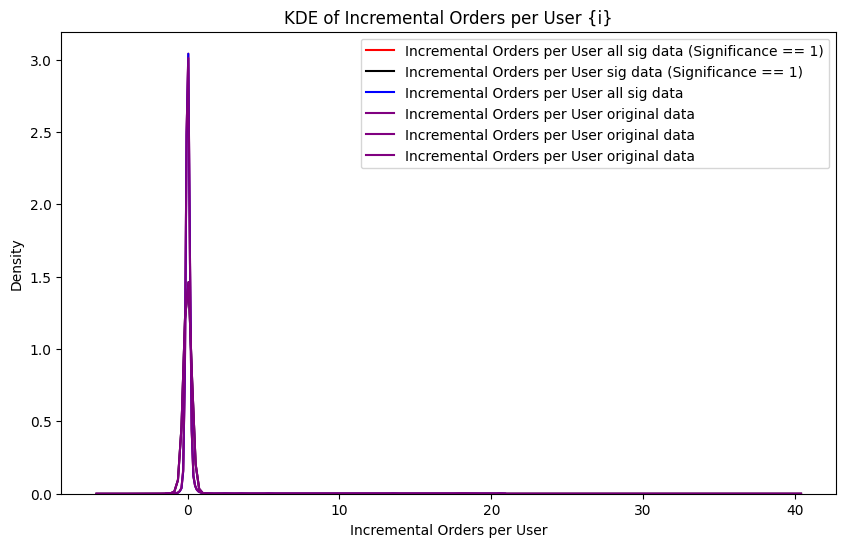

all_data_significance: count    2387.000000
mean        0.041571
std         0.533403
min        -1.078444
25%        -0.006527
50%         0.007144
75%         0.032465
max        20.567399
Name: orders_per_user_incremental, dtype: float64, all_data: count    2387.000000
mean        0.039783
std         1.131137
min        -5.288216
25%        -0.051043
50%         0.002031
75%         0.041436
max        39.689018
Name: flgp_per_user_incremental, dtype: float64, significance_data: count    2387.000000
mean        0.041571
std         0.533403
min        -1.078444
25%        -0.006527
50%         0.007144
75%         0.032465
max        20.567399
Name: orders_per_user_incremental, dtype: float64,ordiginal_data: count    2387.000000
mean        0.039783
std         1.131137
min        -5.288216
25%        -0.051043
50%         0.002031
75%         0.041436
max        39.689018
Name: flgp_per_user_incremental, dtype: float64,ordiginal_data: count    2387.000000
mean        0.038708
std 

In [867]:
# Extract values for a, b, c, d after cleaning
s_a = test_df[test_df['final_rank'] == 1]['orders_per_user_incremental']
s_b = test_df[test_df['final_rank'] == 1]['flgp_per_user_incremental']
s_c = filtered_df['orders_per_user_incremental']
s_d = filtered_df['flgp_per_user_incremental']
s_e = filtered_df1['orders_per_user_incremental']
s_f = filtered_df1['flgp_per_user_incremental']

plt.figure(figsize=(10, 6))

sns.kdeplot(s_a, 
            label='Incremental Orders per User all sig data (Significance == 1)', color='red')

sns.kdeplot(s_b, 
            label='Incremental Orders per User sig data (Significance == 1)', color='black')

sns.kdeplot(s_c, 
            label='Incremental Orders per User all sig data', color='blue')

sns.kdeplot(s_d, 
            label='Incremental Orders per User original data', color='purple')

sns.kdeplot(s_e, 
            label='Incremental Orders per User original data', color='purple')

sns.kdeplot(s_f, 
            label='Incremental Orders per User original data', color='purple')

# Adding labels and legend
plt.xlabel('Incremental Orders per User')
plt.ylabel('Density')
plt.legend()
plt.title('KDE of Incremental Orders per User {i}')

# Show the plot
plt.show()

# Print descriptive statistics
print(f"all_data_significance: {s_a.describe()}, all_data: {s_b.describe()}, significance_data: {s_c.describe()},ordiginal_data: {s_d.describe()},ordiginal_data: {s_e.describe()},ordiginal_data: {s_f.describe()} ")
#significance_stats_all, test_flgp_stats

In [868]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lst_m1  = []
lst_m2  = []
lst_m3  = []
lst_m4  = []

# Assuming test_df_sig is a defined DataFrame
countries = test_df_sig['country_name'].unique()

for i in countries:
    # Filter data for the current country
    df = test_df_sig[test_df_sig['country_name'] == i]
    s_a = df['flgp_per_user_incremental']
    
    # Original KDE plot
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a, label='Original', color='red')
    avg_value = np.mean(s_a)
    median_value = np.median(s_a)
    lst_m1.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Original KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()
    
    # 1. Transformation (Box-Cox)
    if (s_a > 0).all():  # Box-Cox requires positive values
        s_a_boxcox, _ = boxcox(s_a)
        #plt.figure(figsize=(10, 6))
        #sns.kdeplot(s_a_boxcox, label='Box-Cox Transformed', color='green')
        avg_value = np.mean(s_a_boxcox)
        median_value = np.median(s_a_boxcox)
        lst_m2.append(avg_value)
        # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
        # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
        # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
        # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
        # plt.title(f'Box-Cox Transformed KDE - {i}')
        # plt.xlabel('Transformed FLGP per User')
        # plt.ylabel('Density')
        # plt.legend()
        # plt.show()

    # 2. Removing Outliers (Z-score)
    z_scores = np.abs((s_a - np.mean(s_a)) / np.std(s_a))
    s_a_filtered = s_a[z_scores < 3]
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a_filtered, label='Outliers Removed (Z-Score)', color='orange')
    avg_value = np.mean(s_a_filtered)
    median_value = np.median(s_a_filtered)
    lst_m3.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Outliers Removed KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()
    
    # 3. Clipping Extreme Values
    lower_bound, upper_bound = np.percentile(s_a, [5, 95])
    s_a_clipped = np.clip(s_a, lower_bound, upper_bound)
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a_clipped, label='Clipped Values', color='purple')
    avg_value = np.mean(s_a_clipped)
    median_value = np.median(s_a_clipped)
    lst_m4.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Clipped KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()


In [869]:
## significance vs non-significant data check impact

def create_change_columns(all_data, all_sig_data, sig_data):

    all_data['perc_change_opu'] = all_data['orders_per_user_incremental'] / all_data['orders_per_user_control']
    all_data['perc_change_flgpu'] = all_data['flgp_per_user_incremental'] / all_data['flgpu_control']

    all_sig_data['perc_change_opu_sig_all'] = all_sig_data['orders_per_user_incremental'] / all_sig_data['orders_per_user_control']
    all_sig_data['perc_change_flgpu_sig_all'] = all_sig_data['flgp_per_user_incremental'] / all_sig_data['flgpu_control']

    sig_data['per_change_sig_opu'] = test_df_sig['incremental_orders_per_user_sig'] / test_df_sig['orders_per_user_control_sig']

    return all_data, all_sig_data, sig_data


def remove_outliers(df, column, group_column='country_code'):
    
    def filter_outliers_iq(group):
        q1 = group[column].quantile(0.04)
        q3 = group[column].quantile(0.96)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

    def filter_outliers_percentile(group):
        q1 = group[column].quantile(0.01)
        q3 = group[column].quantile(0.99)
    
        return group[(group[column] >= q1) & (group[column] <= q3)]
    
    return df.groupby(group_column, group_keys=False).apply(filter_outliers_percentile)


all_data = test_df.copy()
all_sig_data = filtered_df1.copy()
sig_data = significance_df.copy()

all_data, all_sig_data, sig_data = create_change_columns(all_data, all_sig_data, sig_data)

# all_data = remove_outliers(all_data, 'perc_change_opu')
# all_sig_data = remove_outliers(all_sig_data, 'perc_change_opu_sig_all')
# sig_data = remove_outliers(sig_data, 'per_change_sig_opu')

all_data = remove_outliers(all_data, 'perc_change_flgpu')
all_sig_data = remove_outliers(all_sig_data, 'perc_change_flgpu_sig_all')
#sig_data = remove_outliers(sig_data, 'per_change_sig_opu')


def calculate_sig_difference(
    base_control, oppc, oppc2, avg_total_active_users, total_exponent, increment
):  

    # Calculate number of steps for incremental application
    num_steps = int(total_exponent / increment) + 1

    # Generate exponents
    exponents = [i * increment for i in range(num_steps)]

    # Calculate results for OPPC and OPPC2
    results_oppc = [base_control * (oppc ** exp) * avg_total_active_users for exp in exponents]
    results_oppc2 = [base_control * (oppc2 ** exp) * avg_total_active_users for exp in exponents]

    # Get the first and last values for both OPPC and OPPC2 results
    first_value_oppc = results_oppc[0]
    last_value_oppc = results_oppc[-1]
    first_value_oppc2 = results_oppc2[0]
    last_value_oppc2 = results_oppc2[-1]

    return (last_value_oppc - first_value_oppc) - (last_value_oppc2 - first_value_oppc2)


def sig_diff_summary(df, agg): 

    lst = [] 
    summation = 0

    if agg == 'profit':
        
        df = remove_outliers(df, 'perc_change_flgpu_sig_all') 
        significance = 'significance_profit_per_user'
        metric = 'perc_change_flgpu_sig_all'
        base = 'flgpu_control'

    elif agg == 'orders':

        df = remove_outliers(df, 'perc_change_opu_sig_all')
        significance = 'significance_orders_per_user'
        metric = 'perc_change_opu_sig_all'
        base = 'orders_per_user_control'


    for i in df['country_name'].unique():
        
        tmp = df[df['country_name'] == i]
        sig_average = tmp[tmp[significance] == 1][metric].mean()
        all_average = tmp[metric].mean()
        avg_control = tmp[base].mean()
            
        total_users = tmp['users_control'] + tmp['users_variation']

        # Test the function with given parameters
        oppc = (1 + sig_average)
        oppc2 = (1 + all_average)
        avg_total_active_users = total_users.mean()
        total_exponent = 4
        increment = 1

        result = calculate_sig_difference(
            avg_control, oppc, oppc2, avg_total_active_users, total_exponent, increment
        )
        
        if result is not None and not pd.isna(result):  # Use pandas to check for missing values
            lst.append((i, result))
            summation += result

    return lst, summation


def create_cumulative_difference_chart(cumulative_differences, total_sum, color):
   
    # Prepare data for the bar chart
    countries = [item[0] for item in cumulative_differences]
    differences = [item[1] for item in cumulative_differences]

    # Example DataFrame
    chart_data = pd.DataFrame({
        'Country': countries,
        'Cumulative Difference': differences
    })

    # Create the bar chart
    fig = px.bar(
        chart_data,
        x="Cumulative Difference",
        y="Country",
        orientation='h',
        title="Cumulative Differences Between Significant and Significant + Non-significant Data by Country",
        labels={"Cumulative Difference": "Cumulative Difference", "Country": "Country Code"},
        color="Cumulative Difference",
        color_continuous_scale= color
    )

    # Update layout for better readability and increased height
    fig.update_layout(
        xaxis_title="Cumulative Difference",
        yaxis_title="Country Name",
        coloraxis_showscale=True,
        template="plotly_white",
        margin=dict(l=80, r=20, t=100, b=40),  # Increased top margin for annotation
        height=800  # Increased height
    )

    # Add the annotation at the top
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.5, y=1.15,  # Position above the chart
        text=f"Total Sum of Differences: {total_sum:.2f}",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="center"
    )

    fig.show()

cumulative_differences_orders, total_sum_orders = sig_diff_summary(all_sig_data, 'orders')
create_cumulative_difference_chart(cumulative_differences_orders, total_sum_orders, 'Reds')

cumulative_differences_profit, total_sum_profit = sig_diff_summary(all_sig_data, 'profit')
create_cumulative_difference_chart(cumulative_differences_profit, total_sum_profit, 'Blues')


# # Prepare data for the bar chart
# countries = [item[0] for item in cumulative_differences]
# differences = [item[1] for item in cumulative_differences]

# # Example DataFrame
# chart_data = pd.DataFrame({
#     'Country': countries,
#     'Cumulative Difference': differences
# })

# # Create the bar chart
# fig = px.bar(
#     chart_data,
#     x="Cumulative Difference",
#     y="Country",
#     orientation='h',
#     title="Cumulative Differences Between Significant and Significant + Non-significant Data by Country",
#     labels={"Cumulative Difference": "Cumulative Difference", "Country": "Country Code"},
#     color="Cumulative Difference",
#     color_continuous_scale="Reds"
# )

# # Update layout for better readability and increased height
# fig.update_layout(
#     xaxis_title="Cumulative Difference",
#     yaxis_title="Country Name",
#     coloraxis_showscale=True,
#     template="plotly_white",
#     margin=dict(l=80, r=20, t=100, b=40),  # Increased top margin for annotation
#     height=800  # Increased height
# )

# # Add the annotation at the top
# fig.add_annotation(
#     xref="paper", yref="paper",
#     x=0.5, y=1.15,  # Position above the chart
#     text=f"Total Sum of Differences: {total_sum:.2f}",
#     showarrow=False,
#     font=dict(size=14, color="black"),
#     align="center"
# )

# # Show the interactive chart
# fig.show()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/4215754751.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/4215754751.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/4215754751.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/4215754751.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [870]:
# Step 1 Caluclate the median test duration and median variation share for each country 

# Function to create test_capacity
def create_duration_df(df, days_slack = 7, total_days = 330):
    
    duration_df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
        test_length=('test_length', lambda x: (x + days_slack)[x > 7].median())
    ).reset_index().rename(columns={'test_length': 'median_test_length_days'})
    
    duration_df['testing_capacity'] = round(total_days / duration_df['median_test_length_days'], 2)
    
    return duration_df

duration_df = create_duration_df(filtered_df)

In [871]:
# Step 2 Calculate the total users and average baseline flgpu and orders_per_user

from datetime import datetime

# Ensure Month column is in datetime format
seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'])

# Define the function for averaging the last 6 months for the current year
def last_6_months_avg_current_year(group):
    # Filter to only include data from the current year
    current_year = datetime.now().year
    group = group[group['Month'].dt.year == current_year]
    
    if not group.empty:
        # Find the latest date in the current year group
        latest_date = group['Month'].max()
        # Filter to the last 6 months
        last_6_months = group[group['Month'] >= (latest_date - pd.DateOffset(months=6))]
        
        # Calculate the averages
        avg_total_active_users = last_6_months['total_users'].mean()
        avg_flgp_per_user = last_6_months['flgpu_eur'].mean()
        avg_orders_per_user = last_6_months['orders_per_user'].mean()
        
        return pd.Series({
            'avg_total_active_users': avg_total_active_users,
            'avg_flgp_per_user': avg_flgp_per_user,
            'avg_orders_per_user': avg_orders_per_user
        })
    else:
        # Return NaN for each column if the group is empty
        return pd.Series({
            'avg_total_active_users': float('nan'),
            'avg_flgp_per_user': float('nan'),
            'avg_orders_per_user': float('nan')
        })

# Apply the function to the DataFrame grouped by the specified columns
users_df = seasonal_df.groupby('entity_id').apply(last_6_months_avg_current_year).reset_index()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/96764807.py:39: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [872]:
# Step 3 Calculate the share of tests for different scenarios 

def test_pecentage(df):
    
    pivot_table = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        {'test_id': 'nunique'}
    ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
                                columns='scenario', values='test_id', fill_value=0)
    
    pivot_table = pivot_table.reset_index()
    
    pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
                                 pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
    pivot_table['percentage_growth'] = (pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_lose_lose'] = (pivot_table['Lose-Lose'] / pivot_table['Total_tests'])
    pivot_table['percentage_profit'] = (pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_win_win'] = (pivot_table['Win-Win'] / pivot_table['Total_tests'])
    
    return pivot_table

test_perc_df = test_pecentage(filtered_df)

In [873]:
# Step 4 Calculate the incremental percentage change for flgpu and orders_per_user

def calculate_incremental_means(df):
    
    # Define target countries and scenarios
    target_countries_first = ['Venezuela', 'Honduras']
    target_scenarios_first = ['Win-Win']

    target_countries_second = ['Slovakia']
    target_scenarios_second = ['CPiO - Growth at a Cost']

    target_countries_third = ['Jordan']
    target_scenarios_third = ['Win-Win']

    target_countries_fourth = ['Greece']
    target_scenarios_fourth = ['Win-Win']

    target_countries_fifth = ['Peru']
    target_scenarios_fifth = ['MPOL - Profit at a Cost']

    # Define filtering function
    def filter_by_quantiles(group, upper, lower):
        flgp_upper = group['flgp_per_user_incremental'].quantile(upper)
        flgp_lower = group['flgp_per_user_incremental'].quantile(lower)
        return group[(group['flgp_per_user_incremental'] <= flgp_upper) & 
                    (group['flgp_per_user_incremental'] >= flgp_lower)]

    # Apply filtering for the first set of target countries and scenarios
    tmp1 = df[
        (df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))
    ]
    filtered_target_df_1 = tmp1.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp2 = df[
        (df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))
    ]
    filtered_target_df_2 = tmp2.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0.5)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp3 = df[
        (df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))
    ]
    filtered_target_df_3 = tmp3.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp4 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_4 = tmp4.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp5 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_5 = tmp5.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Combine target country and scenario conditions for exclusion
    exclude_conditions = (
        ((df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))) |
        ((df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))) |
        ((df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))) |
        ((df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))) | 
        ((df['country_name'].isin(target_countries_fifth)) & 
        (df['scenario'].isin(target_scenarios_fifth)))
    )

    # Filter for other countries and scenarios
    other_countries_df = df[~exclude_conditions]

    # Perform filtering only for `flgpu_perc_change`
    filtered_df_flgpu = pd.concat([filtered_target_df_1, filtered_target_df_2, filtered_target_df_3, filtered_target_df_4, filtered_target_df_5, other_countries_df], ignore_index=True)

    # Use the unfiltered dataset for `orders_per_user_perc_change`
    unfiltered_df = df.copy()

    # Group and calculate metrics for `flgpu_perc_change` from the filtered data
    flgpu_df = filtered_df_flgpu.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
        flgpu_control_mean=('flgpu_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for FLGP
    flgpu_df['flgpu_perc_change'] = 1 + (flgpu_df['flgp_per_user_incremental'] / abs(flgpu_df['flgpu_control_mean']))

    # Group and calculate metrics for `orders_per_user_perc_change` from the unfiltered data
    orders_df = unfiltered_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
        orders_per_user_control_mean=('orders_per_user_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for orders
    orders_df['orders_per_user_perc_change'] = 1 + (orders_df['orders_per_user_incremental'] / abs(orders_df['orders_per_user_control_mean']))

    # Merge the two datasets
    combined_df = pd.merge(flgpu_df, orders_df, on=['region', 'brand_name', 'entity_id', 'country_name', 'scenario'], how='outer')

    # Pivot table with scenario as columns
    pivot_table = combined_df.pivot_table(
        index=['region', 'brand_name', 'entity_id', 'country_name'],
        columns='scenario',
        values=['flgpu_control_mean', 'orders_per_user_control_mean', 'flgp_per_user_incremental', 'orders_per_user_incremental', 'flgpu_perc_change', 'orders_per_user_perc_change'],
        fill_value=0
    )

    # Flatten the pivot table for a clean structure
    pivot_table_reset = pivot_table.reset_index()
    pivot_table_flat = pivot_table_reset.copy()
    pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
                                                        'entity_id_': 'entity_id', 'country_name_': 'country_name'})

    return pivot_table_flat

incremental_df = calculate_incremental_means(filtered_df)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/3835771747.py:35: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/3835771747.py:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/3835771747.py:53: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [874]:
# # Step 4 Calculate the incremental percentage change for flgpu and orders_per_user


# def calculate_incremental_means(df):
    

#     df_tmp = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
#         orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
#         flgpu_control_mean=('flgpu_control', 'mean'),
#         orders_per_user_control_mean=('orders_per_user_control', 'mean')
#     ).reset_index()


#     df_tmp['flgpu_perc_change'] = 1 + (df_tmp['flgp_per_user_incremental'] / abs(df_tmp['flgpu_control_mean']))
#     df_tmp['orders_per_user_perc_change'] = 1 + (df_tmp['orders_per_user_incremental'] / abs(df_tmp['orders_per_user_control_mean']))

#     # Pivot table with scenario as columns
#     pivot_table_extended_pivot = df_tmp.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                                   columns='scenario',
#                                                                   values=['flgpu_control_mean','orders_per_user_control_mean','flgp_per_user_incremental', 'orders_per_user_incremental','flgpu_perc_change','orders_per_user_perc_change'],
#                                                                   #values=['flgpu_perc_change'],
#                                                                   fill_value=0)
    
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})
    
#     return pivot_table_flat

# incremental_df = calculate_incremental_means(filtered_df)

In [875]:
# Step 4 Merge all of the dataframes

merged_df_first = pd.merge(duration_df, users_df, on =  'entity_id', how='left')
merged_df_second = pd.merge(merged_df_first, test_perc_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')
final_df = pd.merge(merged_df_second, incremental_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')

In [876]:
# Set the discount factor for the calculations
discount_factor = 1

# Define functions to calculate each orders impact (Method 3)
def calculate_orders_growth_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_profit_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_win_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
        row['avg_total_active_users']
    )

# Apply the Method 3 functions to the DataFrame for orders impact
final_df['orders_impact_growth'] = final_df.apply(calculate_orders_growth_method, axis=1)
final_df['orders_impact_profit'] = final_df.apply(calculate_orders_profit_method, axis=1)
final_df['orders_impact_win'] = final_df.apply(calculate_orders_win_method, axis=1)

# Calculate the baseline orders
final_df['baseline_orders'] = final_df['avg_total_active_users'] * final_df['avg_orders_per_user']

# Calculate the final orders impact
final_df['orders_impact_incremental'] = (
    (final_df['orders_impact_growth'] - final_df['baseline_orders']) +
    (final_df['orders_impact_profit'] - final_df['baseline_orders']) +
    (final_df['orders_impact_win'] - final_df['baseline_orders'])
)


In [877]:
# Set the new discount factor
discount_factor = 1

def calculate_impact_growth_method(row):
    base_value = row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor
    return (
        row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_growth'])) *
        row['avg_total_active_users']
    )

def calculate_impact_profit_method(row):
    base_value = row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor
    return (
        row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_profit'])) *
        row['avg_total_active_users']
    )

def calculate_impact_win_method(row):
    base_value = row['flgpu_perc_change_Win-Win'] * discount_factor
    return (
       row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_win_win'])) *
        row['avg_total_active_users']
    )

# Apply the updated functions to the DataFrame
final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# Calculate the baseline FLGP
final_df['baseline_flgp'] = final_df['avg_total_active_users'] * final_df['avg_flgp_per_user']

# Calculate the final impact using the updated results
final_df['flgp_impact_incremental'] = (
    (final_df['flgp_impact_growth'] - final_df['baseline_flgp']) +
    (final_df['flgp_impact_profit'] - final_df['baseline_flgp']) +
    (final_df['flgp_impact_win'] - final_df['baseline_flgp'])
)


In [878]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define a function to calculate orders impact at each exponent level
# def calculate_exponent_orders_impact(row, max_exponent, increment=1):
#     exponents = np.arange(0, max_exponent + increment, increment)
#     growth_impacts = []
#     profit_impacts = []
#     win_impacts = []
    
#     for exp in exponents:
#         growth_impact = (
#             row['avg_orders_per_user'] *
#             ((row['orders_per_user_perc_change_CPiO - Growth at a Cost'] ** exp) * row['avg_total_active_users'])
#         )
#         profit_impact = (
#             row['avg_orders_per_user'] *
#             ((row['orders_per_user_perc_change_MPOL - Profit at a Cost'] ** exp) * row['avg_total_active_users'])
#         )
#         win_impact = (
#             row['avg_orders_per_user'] *
#             ((row['orders_per_user_perc_change_Win-Win'] ** exp) * row['avg_total_active_users'])
#         )
        
#         growth_impacts.append(growth_impact)
#         profit_impacts.append(profit_impact)
#         win_impacts.append(win_impact)
    
#     return exponents, growth_impacts, profit_impacts, win_impacts

# # Visualization of orders impact per exponent by country
# countries = final_df['country_name'].unique()
# max_exponent = 4  # Adjust as needed

# for country in countries:
#     country_data = final_df[final_df['country_name'] == country].iloc[0]
#     exponents, growth_impacts, profit_impacts, win_impacts = calculate_exponent_orders_impact(country_data, max_exponent)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(exponents, growth_impacts, marker='o', linestyle='-', label="Growth Orders Impact")
#     plt.plot(exponents, profit_impacts, marker='s', linestyle='-', label="Profit Orders Impact")
#     plt.plot(exponents, win_impacts, marker='^', linestyle='-', label="Win-Win Orders Impact")
    
#     plt.title(f"Orders Impact by Exponent for {country}")
#     plt.xlabel("Exponent Level")
#     plt.ylabel("Orders Impact")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [879]:
# import numpy as np
# import matplotlib.pyplot as plt

# import numpy as np

# def calculate_impacts(rows, discount_factor):
#     growth_impacts = []
#     profit_impacts = []
#     win_impacts = []
#     baseline_flgps = []
#     incremental_impacts = []

#     for row in rows:
#         try:
#             # Ensure no missing values
#             if None in (
#                 row.get('avg_flgp_per_user'), 
#                 row.get('flgpu_perc_change_CPiO - Growth at a Cost'), 
#                 row.get('flgpu_perc_change_MPOL - Profit at a Cost'), 
#                 row.get('flgpu_perc_change_Win-Win'), 
#                 row.get('avg_total_active_users'),
#                 row.get('testing_capacity'),
#                 row.get('percentage_growth'),
#                 row.get('percentage_profit'),
#                 row.get('percentage_win_win')
#             ):
#                 raise ValueError("Missing data in row")
            
#             # Growth impact calculation
#             base_growth = row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor
#             growth_impact = (
#                 row['avg_flgp_per_user'] *
#                 (np.abs(base_growth) ** (row['testing_capacity'] * row['percentage_growth'])) *
#                 row['avg_total_active_users']
#             )
#             growth_impacts.append(growth_impact)
            
#             # Profit impact calculation
#             base_profit = row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor
#             profit_impact = (
#                 row['avg_flgp_per_user'] *
#                 (np.abs(base_profit) ** (row['testing_capacity'] * row['percentage_profit'])) *
#                 row['avg_total_active_users']
#             )
#             profit_impacts.append(profit_impact)
            
#             # Win impact calculation
#             base_win = row['flgpu_perc_change_Win-Win'] * discount_factor
#             win_impact = (
#                 row['avg_flgp_per_user'] *
#                 (np.abs(base_win) ** (row['testing_capacity'] * row['percentage_win_win'])) *
#                 row['avg_total_active_users']
#             )
#             win_impacts.append(win_impact)
            
#             # Baseline FLGP calculation
#             baseline_flgp = row['avg_total_active_users'] * row['avg_flgp_per_user']
#             baseline_flgps.append(baseline_flgp)
            
#             # Incremental impact calculation
#             incremental_impact = (
#                 (growth_impact - baseline_flgp) +
#                 (profit_impact - baseline_flgp) +
#                 (win_impact - baseline_flgp)
#             )
#             incremental_impacts.append(incremental_impact)

#         except ValueError as e:
#             print(f"ValueError encountered for row: {row}, error: {e}")
#         except TypeError as e:
#             print(f"TypeError encountered for row: {row}, error: {e}")
    
#     return {
#         'growth_impacts': growth_impacts,
#         'profit_impacts': profit_impacts,
#         'win_impacts': win_impacts,
#         'baseline_flgps': baseline_flgps,
#         'incremental_impacts': incremental_impacts
#     }

      
    
#     # growth_impacts = []
#     # profit_impacts = []
#     # win_impacts = []
    
#     # for exp in exponents:
#     #     # growth_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users'])
#     #     # profit_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users'])
#     #     # win_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_Win-Win'] * discount_factor) ** exp) * row['avg_total_active_users'])

#     #     growth_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users']
#     #     profit_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users']
#     #     win_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_Win-Win'] * discount_factor) ** exp) * row['avg_total_active_users']

#     # return exponents, growth_impacts, profit_impacts, win_impacts

# # Visualization of impacts per exponent by country
# countries = final_df['country_name'].unique()
# max_exponent = 4  # Adjust as needed

# for country in countries:
#     country_data = final_df[final_df['country_name'] == country].iloc[0]
#     exponents, growth_impacts, profit_impacts, win_impacts = calculate_exponent_impact(country_data, max_exponent)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(exponents, growth_impacts, marker='o', linestyle='-', label="Growth Impact")
#     plt.plot(exponents, profit_impacts, marker='s', linestyle='-', label="Profit Impact")
#     plt.plot(exponents, win_impacts, marker='^', linestyle='-', label="Win-Win Impact")
    
#     plt.title(f"FLGP Impact by Exponent for {country}")
#     plt.xlabel("Exponent Level")
#     plt.ylabel("Impact")
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [880]:
def calculate_yoy_growth(df, target_year=2024, base_year=2023):
    """
    Calculate Year-over-Year (YoY) growth for fully loaded gross profit, orders, and users.
    Fills missing target year values based on the average YoY growth for each entity.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'Month', 'entity_id', 'fully_loaded_gross_profit_eur',
                           'total_orders', and 'total_users' columns.
        target_year (int): The year for which we want to fill missing values (default is 2024).
        base_year (int): The base year for calculating YoY growth (default is 2023).
    
    Returns:
        pd.DataFrame: A DataFrame with aggregated total values for each entity in both the base and target years.
    """
    df = df.copy()

    # Extract month and year from the date column
    df['Month_o'] = pd.to_datetime(df['Month']).dt.month
    df['Year_o'] = pd.to_datetime(df['Month']).dt.year

    # Initialize an empty DataFrame to store results for all entities
    all_entities_results = pd.DataFrame()

    # Get unique entities
    entities = df['entity_id'].unique()

    # Loop through each entity to calculate metrics and fill missing target year values
    for entity in entities:
        # Filter data for the current entity
        entity_df = df[df['entity_id'] == entity]

        pivot_df = entity_df.pivot_table(
            index=['entity_id', 'Month_o'],
            columns='Year_o', 
            values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'], 
            fill_value=0
        ).reset_index()

        # Flatten the multi-level columns to a single level
        pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

        pivot_df.rename(columns={'entity_id_': 'entity_id'}, inplace = True)

        # Calculate percentage change for each metric
        pivot_df["profit_yoy_change"] = np.where(
            pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] != 0,
            ((pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] - pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]) /
             pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]),
            np.nan
        )
        
        pivot_df["orders_yoy_change"] = np.where(
            pivot_df[f"total_orders_{target_year}"] != 0,
            ((pivot_df[f"total_orders_{target_year}"] - pivot_df[f"total_orders_{base_year}"]) /
             pivot_df[f"total_orders_{base_year}"]),
            np.nan
        )

        pivot_df["users_yoy_change"] = np.where(
            pivot_df[f"total_users_{target_year}"] != 0,
            ((pivot_df[f"total_users_{target_year}"] - pivot_df[f"total_users_{base_year}"]) /
             pivot_df[f"total_users_{base_year}"]),
            np.nan
        )

        # Calculate average YoY changes
        average_yoy_profit = pivot_df["profit_yoy_change"].mean()
        average_yoy_orders = pivot_df["orders_yoy_change"].mean()
        average_yoy_users = pivot_df["users_yoy_change"].mean()

        # Fill missing target year values based on average YoY change
        pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] = np.where(
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] == 0,
            pivot_df[f'fully_loaded_gross_profit_eur_{base_year}'] * (1 + average_yoy_profit),
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}']
        )
        
        pivot_df[f'total_orders_{target_year}'] = np.where(
            pivot_df[f'total_orders_{target_year}'] == 0,
            pivot_df[f'total_orders_{base_year}'] * (1 + average_yoy_orders),
            pivot_df[f'total_orders_{target_year}']
        )
        
        pivot_df[f'total_users_{target_year}'] = np.where(
            pivot_df[f'total_users_{target_year}'] == 0,
            pivot_df[f'total_users_{base_year}'] * (1 + average_yoy_users),
            pivot_df[f'total_users_{target_year}']
        )

        all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

    # Aggregate results for each entity
    result_df = all_entities_results.groupby('entity_id').agg({
        f'total_orders_{base_year}': 'sum',
        f'total_orders_{target_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{base_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{target_year}': 'sum',
        f'total_users_{base_year}': 'sum',
        f'total_users_{target_year}': 'sum'
    }).reset_index()

    result_df['total_flgp'] = result_df['fully_loaded_gross_profit_eur_2024']
    result_df['total_orders'] = result_df['total_orders_2024']
    result_df['total_users'] = result_df['total_users_2024']

    return result_df


impact_df = calculate_yoy_growth(seasonal_df)

In [881]:
(final_df['flgp_impact_incremental'].sum() / (impact_df['total_flgp'].sum())) * 100

0.8388313558429261

In [882]:
(final_df['orders_impact_incremental'].sum() / (impact_df['total_orders'].sum())) * 100

1.1624005632081273

In [883]:
impact_df_final = pd.merge(final_df, impact_df, on='entity_id', how='left')

impact_df_final['total_flgp_target'] = impact_df_final['total_flgp'] + impact_df_final['flgp_impact_incremental']
impact_df_final['total_orders_target'] = impact_df_final['total_orders'] + impact_df_final['orders_impact_incremental']
impact_df_final['flgp_yoy_2024'] = (impact_df_final['fully_loaded_gross_profit_eur_2024'] - impact_df_final['fully_loaded_gross_profit_eur_2023']) / impact_df_final['fully_loaded_gross_profit_eur_2023']
impact_df_final['orders_yoy_2024'] = (impact_df_final['total_orders_2024'] - impact_df_final['total_orders_2023']) / impact_df_final['total_orders_2023']

impact_df_final.to_csv('combined_targets.csv', index=False)

In [884]:
summary_df = impact_df_final.groupby('brand_name').agg({'total_orders_target':'sum','total_flgp_target':'sum','flgp_impact_incremental':'sum','orders_impact_incremental':'sum','fully_loaded_gross_profit_eur_2023':'sum','fully_loaded_gross_profit_eur_2024':'sum','total_orders_2024':'sum','total_orders_2023':'sum'}).reset_index()

# Calculate the total for each column in summary_df, excluding 'brand_name'
totals = summary_df[['total_orders_target', 'total_flgp_target', 'flgp_impact_incremental', 
                     'orders_impact_incremental', 'fully_loaded_gross_profit_eur_2023', 
                     'fully_loaded_gross_profit_eur_2024', 'total_orders_2024', 
                     'total_orders_2023']].sum()

# Convert the totals to a DataFrame row
totals_df = pd.DataFrame([totals], columns=totals.index)

# Add a 'brand_name' for the totals row
totals_df.insert(0, 'brand_name', 'Total')

# Append the totals row to the summary_df
summary_df = pd.concat([summary_df, totals_df], ignore_index=True)

# Display the summary DataFrame with totals row
summary_df['perc_flgp'] = summary_df['flgp_impact_incremental'] / summary_df['total_flgp_target']
summary_df['perc_orders'] = summary_df['orders_impact_incremental'] / summary_df['total_orders_target']

summary_df


summary_df.to_csv('summary_impact.csv', index=False)

In [885]:
summary_df

,brand_name,total_orders_target,total_flgp_target,flgp_impact_incremental,orders_impact_incremental,fully_loaded_gross_profit_eur_2023,fully_loaded_gross_profit_eur_2024,total_orders_2024,total_orders_2023,perc_flgp,perc_orders
0,Foodora,5.143443e+07,1.019908e+08,-5.211135e+05,8.855593e+05,1.166665e+08,1.025119e+08,5.054887e+07,41949707.0,-0.005109,0.017217
1,Foodpanda,5.071536e+08,2.964044e+08,1.565512e+06,9.263028e+06,3.316111e+08,2.948389e+08,4.978906e+08,548328397.0,0.005282,0.018265
2,Foody,4.775224e+06,5.976414e+06,-3.057161e+05,4.305223e+03,2.529987e+06,6.282130e+06,4.770919e+06,2641885.0,-0.051154,0.000902
3,HungerStation,1.527681e+08,4.991435e+08,-1.416296e+06,1.146726e+06,4.120509e+08,5.005598e+08,1.516214e+08,128872746.0,-0.002837,0.007506
4,PedidosYa,2.016152e+08,2.246157e+08,8.948705e+05,1.799931e+06,2.150745e+08,2.237208e+08,1.998152e+08,174698206.0,0.003984,0.008928
5,Talabat,3.113030e+08,5.787191e+08,1.092860e+07,1.592099e+06,4.156088e+08,5.677905e+08,3.097109e+08,232334442.0,0.018884,0.005114
6,Yemeksepeti,1.066527e+08,4.855539e+07,1.134684e+06,8.933554e+05,1.996776e+06,4.742070e+07,1.057593e+08,33035636.0,0.023369,0.008376
7,eFood,1.970665e+07,2.452918e+07,2.525911e+06,-1.075779e+04,3.586599e+06,2.200327e+07,1.971740e+07,8404450.0,0.102976,-0.000546
8,Total,1.355409e+09,1.779934e+09,1.480645e+07,1.557425e+07,1.499125e+09,1.765128e+09,1.339835e+09,1170265469.0,0.008319,0.011490


In [886]:
1,372,277,312	€1,844,052,983

SyntaxError: invalid character '€' (U+20AC) (643366752.py, line 1)

In [ ]:
## Glovo Data ##

glovo_actuals = pd.read_csv('Glovo_monthly_actuals - Sheet1.csv')
glovo_test_data = pd.read_csv('Glovo_test_data_final - test_data.csv')

glovo_country_mapping = {
    "country_code": ["ES", "IT", "PL", "PT", "AD", "RO", "RS", "HR", "BG", "SI", "ME", "BA", "MD", "UA", "KZ", "GE", "KG", "AM", "MA", "KE", "CI", "GH", "TN", "NG", "UG"],
    "country_name": [
        "Spain", "Italy", "Poland", "Portugal", "Andorra", "Romania", "Serbia", "Croatia", "Bulgaria", 
        "Slovenia", "Montenegro", "Bosnia and Herzegovina", "Moldova", "Ukraine", "Kazakhstan", 
        "Georgia", "Kyrgyzstan", "Armenia", "Morocco", "Kenya", "Côte d'Ivoire", "Ghana", 
        "Tunisia", "Nigeria", "Uganda"
    ]
}

country_df = pd.DataFrame(glovo_country_mapping)

data = {
    'country_code': ['BA', 'ME', 'MD', 'BG', 'HR', 'UG', 'RO', 'KE', 'RS', 'CI', 'NG', 
                'PT', 'AM', 'PL', 'GE', 'IT', 'UA', 'MA', 'TN', 'KG', 'KZ', 'ES', 'AD'],
    'migration_date': ['05-Aug-24', '26-Aug-24', '02-Sep-24', '16-Sep-24', '16-Sep-24', 
             '16-Sep-24', '07-Oct-24', '07-Oct-24', '07-Oct-24', '21-Oct-24', 
             '21-Oct-24', '04-Dec-24', '18-Nov-24', '17-Feb-25', '17-Feb-25', 
             '10-Mar-25', '17-Mar-25', '11-Nov-24', '04-Nov-24', '24-Feb-25', 
             '24-Feb-25', '31-Mar-25', '31-Mar-25']
}

migration_df = pd.DataFrame(data)

migration_df['migration_date'] = pd.to_datetime(migration_df['migration_date'], format='%d-%b-%y')

relevant_cities = [
    'Armenia', 'Bosnia and Herzegovina', 'Bulgaria', "Côte d'Ivoire", 'Spain', 'Georgia', 
    'Croatia', 'Italy', 'Kenya', 'Kyrgyzstan', 'Kazakhstan', 'Morocco', 'Moldova', 
    'Montenegro', 'Nigeria', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Tunisia', 
    'Ukraine', 'Uganda'
]

glovo_test_data['country_code'] = glovo_test_data['CC']

g_test_data = pd.merge(glovo_test_data, migration_df, on = 'country_code', how = 'left')
g_test_data = pd.merge(g_test_data, country_df, on = 'country_code', how = 'left')

In [ ]:
## Step 1


# Convert date column to datetime format
g_test_data["migration_date"] = pd.to_datetime(g_test_data["migration_date"])

# Add 30 days to the date
g_test_data["date_plus_30"] = g_test_data["migration_date"] + pd.Timedelta(days=30)

# Calculate the new column based on the conditions
end_of_2025 = pd.Timestamp("2025-12-31")

def calculate_new_column(row):
    date_plus_30 = row["date_plus_30"]
    if date_plus_30.year == 2024:
        return 330
    elif date_plus_30.year == 2025:
        days_difference = (end_of_2025 - date_plus_30).days
        return days_difference - 35
    return None

g_test_data["days_available"] = g_test_data.apply(calculate_new_column, axis=1)

g_test_data['start_date'] = pd.to_datetime(g_test_data['Started'], format='%d-%b-%y')
g_test_data['end_date'] = pd.to_datetime(g_test_data['Stopped'], format='%d-%b-%y')

g_test_data['test_length'] = (g_test_data['end_date'] - g_test_data['start_date']).dt.days

duration_df_glovo = g_test_data.groupby(['Region', 'country_name','country_code']).agg(
    test_length=('test_length', lambda x: (x + 7)[x > 7].median())
).reset_index().rename(columns={'test_length': 'median_test_length_days'})


testing_days = g_test_data[['country_name', 'days_available']].drop_duplicates()

duration_df_glovo = pd.merge(duration_df_glovo, testing_days, on = 'country_name', how = 'left')

duration_df_glovo['testing_capacity'] = round(duration_df_glovo['days_available'] / duration_df_glovo['median_test_length_days'], 2)

duration_df_glovo

,Region,country_name,country_code,median_test_length_days,days_available,testing_capacity
0,Africa,Côte d'Ivoire,CI,69.5,330.0,4.75
1,Africa,Kenya,KE,65.0,330.0,5.08
2,Africa,Morocco,MA,84.0,330.0,3.93
3,Africa,Nigeria,NG,49.0,330.0,6.73
4,Africa,Tunisia,TN,76.0,330.0,4.34
5,Africa,Uganda,UG,92.0,330.0,3.59
6,ECA,Armenia,AM,69.0,330.0,4.78
7,ECA,Georgia,GE,82.0,252.0,3.07
8,ECA,Kazakhstan,KZ,105.0,245.0,2.33
9,ECA,Kyrgyzstan,KG,108.0,245.0,2.27


In [ ]:
## Step 2

# Remove commas and convert columns to numeric
glovo_actuals['total CM'] = glovo_actuals['total CM'].str.replace(',', '').astype(float)
glovo_actuals['MAUs'] = glovo_actuals['MAUs'].str.replace(',', '').astype(float)
glovo_actuals['total orders'] = glovo_actuals['total orders'].str.replace(',', '').astype(float)

# Perform the calculations
glovo_actuals['flgpu_eur'] = glovo_actuals['total CM'] / glovo_actuals['MAUs']
glovo_actuals['orders_per_user'] = glovo_actuals['total orders'] / glovo_actuals['MAUs']

# Convert the date column to datetime format
glovo_actuals['date'] = pd.to_datetime(glovo_actuals['date'], errors='coerce')

# Extract the month and year
glovo_actuals['Month'] = glovo_actuals['date'].dt.month
glovo_actuals['year'] = glovo_actuals['date'].dt.year

def last_6_months_avg_current_year(group):
    # Filter to only include data from the current year
    current_year = datetime.now().year
    group = group[group['date'].dt.year == current_year]
    
    if not group.empty:
        # Find the latest date in the current year group
        latest_date = group['date'].max()
        # Filter to the last 6 months
        last_6_months = group[group['date'] >= (latest_date - pd.DateOffset(months=6))]
        
        # Calculate the averages
        avg_total_active_users = last_6_months['MAUs'].mean()
        avg_flgp_per_user = last_6_months['flgpu_eur'].mean()
        avg_orders_per_user = last_6_months['orders_per_user'].mean()
        
        return pd.Series({
            'avg_total_active_users': avg_total_active_users,
            'avg_flgp_per_user': avg_flgp_per_user,
            'avg_orders_per_user': avg_orders_per_user
        })
    else:
        # Return NaN for each column if the group is empty
        return pd.Series({
            'avg_total_active_users': float('nan'),
            'avg_flgp_per_user': float('nan'),
            'avg_orders_per_user': float('nan')
        })

# Apply the function to the DataFrame grouped by the specified columns
users_df_glovo = glovo_actuals.groupby('country_name').apply(last_6_months_avg_current_year).reset_index()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_19532/2850127341.py:49: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
#  Step 3 Calculate the share of tests for different scenarios 

# Mapping dictionary
value_mapping = {
    'MPOL': 'MPOL - Profit at a Cost',
    'CPiO': 'CPiO - Growth at a Cost',
    'Jackpot': 'Win-Win',
    'No Go': 'Lose-Lose'
}

# Replace values in the DataFrame
g_test_data['Scenario'] = g_test_data['Scenario'].replace(value_mapping)

def test_pecentage(df):
    
    pivot_table = df.groupby(['Region', 'country_name', 'Scenario']).agg(
        {'Name': 'count'}
    ).reset_index().pivot_table(index=['Region', 'country_name'],
                                columns='Scenario', values='Name', fill_value=0)
    
    pivot_table = pivot_table.reset_index()

    percentage_growth_average = pivot_table[pivot_table['CPiO - Growth at a Cost'] > 0]['CPiO - Growth at a Cost'].mean()
    percentage_lose_average = pivot_table[pivot_table['Lose-Lose'] > 0]['Lose-Lose'].mean()
    percentage_profit_average = pivot_table[pivot_table['MPOL - Profit at a Cost'] > 0]['MPOL - Profit at a Cost'].mean()
    percentage_win_average = pivot_table[pivot_table['Win-Win'] > 0]['Win-Win'].mean()

    pivot_table.loc[pivot_table['CPiO - Growth at a Cost'] == 0, 'CPiO - Growth at a Cost'] = percentage_growth_average
    pivot_table.loc[pivot_table['Lose-Lose'] == 0, 'Lose-Lose'] = percentage_lose_average
    pivot_table.loc[pivot_table['MPOL - Profit at a Cost'] == 0, 'MPOL - Profit at a Cost'] = percentage_profit_average
    pivot_table.loc[pivot_table['Win-Win'] == 0, 'Win-Win'] = percentage_win_average
    
    pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
                                 pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
    pivot_table['percentage_growth'] = (pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_lose_lose'] = (pivot_table['Lose-Lose'] / pivot_table['Total_tests'])
    pivot_table['percentage_profit'] = (pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_win_win'] = (pivot_table['Win-Win'] / pivot_table['Total_tests'])
    
    return pivot_table

test_perc_df_glovo = test_pecentage(g_test_data)



In [ ]:
g_test_data = g_test_data[g_test_data['Rollout?'] == 'Y']

g_test_data['start_date_beg'] = pd.to_datetime(g_test_data['start_date']).dt.to_period('M').dt.to_timestamp()
g_test_data['end_date_beg'] = pd.to_datetime(g_test_data['end_date']).dt.to_period('M').dt.to_timestamp()

# Function to calculate total orders divided by the number of months
def users_proxy(row):
    
    # Filter rows in df2 between start_date and end_date
    mask = ((glovo_actuals['date'] >= row['start_date_beg']) & (glovo_actuals['date'] <= row['end_date_beg']) & (glovo_actuals['country_name'] == row['country_name']))
    filtered_df = glovo_actuals[mask]
    if not filtered_df.empty:
        # Calculate total orders
        total_orders = filtered_df['MAUs'].sum()
        # Calculate the number of months (inclusive)
        num_months = (row['end_date_beg'].to_period('M') - row['start_date_beg'].to_period('M')).n + 1
        return total_orders / num_months
    return None

# Apply the function to each row in df1
g_test_data['total_users'] = g_test_data.apply(users_proxy, axis=1) 

# Count non-null values in columns A, B, C, D
g_test_data['non_null_count'] = g_test_data[['variation_A_orders', 'variation_B_orders', 'variation_C_orders', 'variation_D_orders']].notnull().sum(axis=1)

# Apply the division logic
g_test_data['adjusted_users'] = g_test_data['total_users'] / (g_test_data['non_null_count'] + 1)

In [ ]:
# Ensure all relevant columns are numeric by removing unwanted characters and converting data types
columns_to_clean = [
    'variation_A_orders', 'variation_B_orders', 'variation_C_orders',
    'variation_D_orders', 'control_orders', 'control_cm',
    'Variation_A_cm', 'Variation_B_cm', 'Variation_C_cm', 'Variation_D_cm', 'adjusted_users'
]

for col in columns_to_clean:
    if g_test_data[col].dtype == 'object':  # Check if column is a string
        g_test_data[col] = (
            g_test_data[col]
            .str.replace(',', '', regex=False)  # Remove commas
            .str.replace('€', '', regex=False)  # Remove euro signs
            .astype(float)  # Convert to float
        )

# Ensure the `adjusted_users` column is numeric
if g_test_data['adjusted_users'].dtype == 'object':
    g_test_data['adjusted_users'] = (
        g_test_data['adjusted_users']
        .str.replace(',', '', regex=False)
        .astype(float)
    )

# Define functions to select orders and CMU based on the winning variation
def select_orders(row):
    if row['Winning Var'] == 'Variation A':
        return row['variation_A_orders']
    elif row['Winning Var'] == 'Variation B':
        return row['variation_B_orders']
    elif row['Winning Var'] == 'Variation C':
        return row['variation_C_orders']
    else:
        return row['variation_A_orders']  # Default to Variation A orders

def select_cmu(row):
    if row['Winning Var'] == 'Variation A':
        return row['Variation_A_cm']
    elif row['Winning Var'] == 'Variation B':
        return row['Variation_B_cm']
    elif row['Winning Var'] == 'Variation C':
        return row['Variation_C_cm']
    else:
        return row['Variation_A_cm']  # Default to Variation A CMU

# Perform the calculations
g_test_data['orders_per_user_control'] = (
    g_test_data['control_orders'] / g_test_data['adjusted_users']
)

g_test_data['cmu_control'] = (
    (g_test_data['control_orders'] * g_test_data['control_cm']) / g_test_data['adjusted_users']
)

g_test_data['orders_per_user_variation'] = (
    g_test_data.apply(select_orders, axis=1) / g_test_data['adjusted_users']
)

g_test_data['cmu_variation'] = (
    (g_test_data.apply(select_cmu, axis=1) * g_test_data.apply(select_orders, axis=1)) 
    / g_test_data['adjusted_users']
)

g_test_data['orders_per_user_incremental'] = (
    g_test_data['orders_per_user_variation'] - g_test_data['orders_per_user_control']
)

g_test_data['cm_per_user_incremental'] = (
    g_test_data['cmu_variation'] - g_test_data['cmu_control']
)

# Validate and debug results
print(g_test_data.head())
print(g_test_data[['orders_per_user_control', 'cmu_control', 'orders_per_user_variation', 'cmu_variation']].dtypes)


  Region  CC           Cities Type AS overwrite? Migrated? Migration Date  \
0    ECA  KG      OSH,KKL,BSK  MBS           NaN        NO      24-Feb-25   
3    ECA  AM  YRV,VDZ,GYM,AVN   DF             Y       YES      18-Nov-24   
4    ECA  UA              KIE   DF           NaN        NO      24-Mar-25   
5    ECA  UA              KYI   DF           NaN        NO      24-Mar-25   
6    ECA  UA              LVI   DF           NaN        NO      24-Mar-25   

  DPS test?    Started    Stopped  ...  end_date_beg    total_users  \
0        NO  16-Aug-23   4-Jan-24  ...    2024-01-01   60944.333333   
3        NO  22-Nov-23   9-Jan-24  ...    2024-01-01   22671.000000   
4        NO  06-Nov-23  10-Jan-24  ...    2024-01-01  524292.000000   
5        NO  06-Nov-23  10-Jan-24  ...    2024-01-01  524292.000000   
6        NO  06-Nov-23  10-Jan-24  ...    2024-01-01  524292.000000   

  non_null_count adjusted_users orders_per_user_control cmu_control  \
0              1   30472.166667        

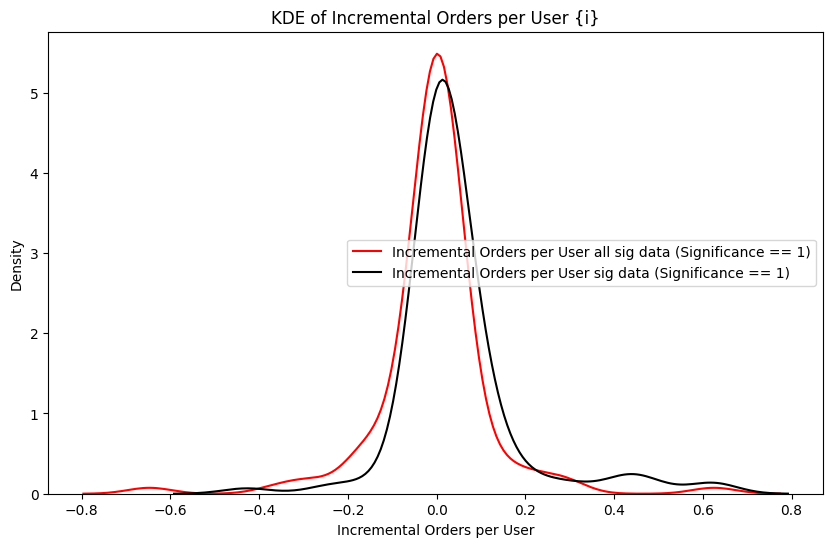

all_data: count    109.000000
mean      -0.004987
std        0.126823
min       -0.647063
25%       -0.024225
50%        0.000822
75%        0.021809
max        0.625012
Name: orders_per_user_incremental, dtype: float64, all_data: count    109.000000
mean       0.046565
std        0.139802
min       -0.427458
25%       -0.002752
50%        0.013022
75%        0.061971
max        0.627639
Name: cm_per_user_incremental, dtype: float64


In [ ]:
g_a = g_test_data['orders_per_user_incremental']
g_b = g_test_data['cm_per_user_incremental']


plt.figure(figsize=(10, 6))

sns.kdeplot(g_a, 
            label='Incremental Orders per User all sig data (Significance == 1)', color='red')

sns.kdeplot(g_b, 
            label='Incremental Orders per User sig data (Significance == 1)', color='black')

# Adding labels and legend
plt.xlabel('Incremental Orders per User')
plt.ylabel('Density')
plt.legend()
plt.title('KDE of Incremental Orders per User {i}')

# Show the plot
plt.show()

# Print descriptive statistics
print(f"all_data: {g_a.describe()}, all_data: {g_b.describe()}")
#significance_stats_all, test_flgp_stats

In [ ]:
# Step 4 Calculate the incremental percentage change for flgpu and orders_per_user

def calculate_incremental_means(df):
    
    df_tmp = df.groupby(['Region','country_name', 'Scenario']).agg(
        flgp_per_user_incremental=('cm_per_user_incremental', 'mean'),
        orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
        flgpu_control_mean=('cmu_control', 'mean'),
        orders_per_user_control_mean=('orders_per_user_control', 'mean')
    ).reset_index()


    df_tmp['flgpu_perc_change'] = 1 + (df_tmp['flgp_per_user_incremental'] / abs(df_tmp['flgpu_control_mean']))
    df_tmp['orders_per_user_perc_change'] = 1 + (df_tmp['orders_per_user_incremental'] / abs(df_tmp['orders_per_user_control_mean']))

    # Pivot table with scenario as columns
    pivot_table_extended_pivot = df_tmp.pivot_table(index=['Region','country_name'],
                                                                  columns='Scenario',
                                                                  values=['flgpu_control_mean','orders_per_user_control_mean','flgp_per_user_incremental', 'orders_per_user_incremental','flgpu_perc_change','orders_per_user_perc_change'],
                                                                  #values=['flgpu_perc_change'],
                                                                  fill_value=0)
    
    pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
    pivot_table_flat = pivot_table_extended_pivot_reset.copy()
    pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
    pivot_table_flat = pivot_table_flat.rename(columns={'Region_': 'Region','country_name_': 'country_name'})
    
    return pivot_table_flat
    
glovo_incremental_df = calculate_incremental_means(g_test_data)

In [ ]:
columns_to_process = [
    'flgp_per_user_incremental_CPiO - Growth at a Cost',
    'flgp_per_user_incremental_Lose-Lose',
    'flgp_per_user_incremental_MPOL - Profit at a Cost',
    'flgp_per_user_incremental_Win-Win',
    'flgpu_control_mean_CPiO - Growth at a Cost',
    'flgpu_control_mean_Lose-Lose',
    'flgpu_control_mean_MPOL - Profit at a Cost',
    'flgpu_control_mean_Win-Win',
    'flgpu_perc_change_CPiO - Growth at a Cost',
    'flgpu_perc_change_Lose-Lose',
    'flgpu_perc_change_MPOL - Profit at a Cost',
    'flgpu_perc_change_Win-Win',
    'orders_per_user_control_mean_CPiO - Growth at a Cost',
    'orders_per_user_control_mean_Lose-Lose',
    'orders_per_user_control_mean_MPOL - Profit at a Cost',
    'orders_per_user_control_mean_Win-Win',
    'orders_per_user_incremental_CPiO - Growth at a Cost',
    'orders_per_user_incremental_Lose-Lose',
    'orders_per_user_incremental_MPOL - Profit at a Cost',
    'orders_per_user_incremental_Win-Win',
    'orders_per_user_perc_change_CPiO - Growth at a Cost',
    'orders_per_user_perc_change_Lose-Lose',
    'orders_per_user_perc_change_MPOL - Profit at a Cost',
    'orders_per_user_perc_change_Win-Win'
]

# Process each column to replace 0 values with the mean of non-zero, non-null values
for column in columns_to_process:
    non_zero_mean = glovo_incremental_df[column][(glovo_incremental_df[column] != 0) & (glovo_incremental_df[column].notnull())].mean()
    glovo_incremental_df[column] = glovo_incremental_df[column].replace(0, non_zero_mean)

In [ ]:
glovo_incremental_df

,Region,country_name,flgp_per_user_incremental_CPiO - Growth at a Cost,flgp_per_user_incremental_Lose-Lose,flgp_per_user_incremental_MPOL - Profit at a Cost,flgp_per_user_incremental_Win-Win,flgpu_control_mean_CPiO - Growth at a Cost,flgpu_control_mean_Lose-Lose,flgpu_control_mean_MPOL - Profit at a Cost,flgpu_control_mean_Win-Win,...,orders_per_user_control_mean_MPOL - Profit at a Cost,orders_per_user_control_mean_Win-Win,orders_per_user_incremental_CPiO - Growth at a Cost,orders_per_user_incremental_Lose-Lose,orders_per_user_incremental_MPOL - Profit at a Cost,orders_per_user_incremental_Win-Win,orders_per_user_perc_change_CPiO - Growth at a Cost,orders_per_user_perc_change_Lose-Lose,orders_per_user_perc_change_MPOL - Profit at a Cost,orders_per_user_perc_change_Win-Win
0,Africa,Côte d'Ivoire,0.056326,-0.095495,0.098667,0.181082,9.807899,5.049129,3.371148,6.000023,...,6.253727,8.897579,0.231380,-0.045478,-0.086953,0.121819,1.018637,0.992234,0.982791,1.013691
1,Africa,Kenya,-0.069623,-0.095495,0.016943,0.166115,3.890378,5.049129,1.387186,4.615877,...,3.907908,7.162157,0.137001,-0.045478,-0.030095,0.027200,1.034777,0.992234,0.992299,1.003798
2,Africa,Morocco,-0.022543,-0.095495,0.012369,0.006737,2.006266,5.049129,1.094319,1.095243,...,1.777718,1.482605,0.021874,-0.045478,-0.011527,0.015518,1.010047,0.992234,0.993516,1.010467
3,Africa,Nigeria,-0.069623,-0.095495,0.131148,0.010420,3.890378,5.049129,0.728168,1.061930,...,7.472361,21.238595,0.137001,-0.045478,-0.188581,0.208391,1.034777,0.992234,0.974763,1.009812
4,Africa,Tunisia,-0.026105,-0.095495,0.049421,0.025672,0.471704,5.049129,0.084480,6.009470,...,0.843241,19.385387,0.040011,-0.045478,-0.068400,0.082813,1.030536,0.992234,0.918885,1.004272
5,Africa,Uganda,-0.069623,-0.095495,0.098667,0.121996,3.890378,5.049129,3.371148,4.530415,...,6.253727,9.974264,0.137001,-0.045478,-0.086953,0.196594,1.034777,0.992234,0.982791,1.019710
6,ECA,Armenia,-0.085920,-0.095495,0.001467,0.099462,6.154552,5.049129,5.672869,3.676661,...,8.015893,7.017667,0.138019,-0.045478,-0.219726,0.058443,1.015474,0.992234,0.972589,1.008419
7,ECA,Georgia,-0.069623,-0.009398,0.020300,0.065691,3.890378,4.954128,6.901843,0.189520,...,14.855608,3.158670,0.137001,-0.020885,-0.103113,0.031472,1.034777,0.998103,0.993059,1.009964
8,ECA,Kazakhstan,-0.069623,-0.095495,0.017161,0.036858,3.890378,5.049129,0.291349,0.451095,...,1.009422,1.780136,0.137001,-0.045478,-0.007499,0.019439,1.034777,0.992234,0.992571,1.010920
9,ECA,Kyrgyzstan,-0.069623,-0.095495,0.273485,0.099462,3.890378,5.049129,5.914525,3.676661,...,6.877355,7.017667,0.137001,-0.045478,-0.077344,0.058443,1.034777,0.992234,0.988754,1.008419


In [ ]:
# Step 4 Merge all of the dataframes

merged_df_first_glovo = pd.merge(duration_df_glovo, users_df_glovo, on =  'country_name', how='left')
merged_df_second_glovo = pd.merge(merged_df_first_glovo, test_perc_df_glovo, on=['Region','country_name'], how='left')
final_df_glovo = pd.merge(merged_df_second_glovo, glovo_incremental_df, on=['Region', 'country_name'], how='left')

In [ ]:
final_df_glovo = final_df_glovo[~final_df_glovo['avg_total_active_users'].isna()]

In [ ]:
# Set the discount factor for the calculations
discount_factor = 1

# Define functions to calculate each orders impact (Method 3)
def calculate_orders_growth_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_profit_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_win_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
        row['avg_total_active_users']
    )

# Apply the Method 3 functions to the DataFrame for orders impact
final_df_glovo['orders_impact_growth'] = final_df_glovo.apply(calculate_orders_growth_method, axis=1)
final_df_glovo['orders_impact_profit'] = final_df_glovo.apply(calculate_orders_profit_method, axis=1)
final_df_glovo['orders_impact_win'] = final_df_glovo.apply(calculate_orders_win_method, axis=1)

# Calculate the baseline orders
final_df_glovo['baseline_orders'] = final_df_glovo['avg_total_active_users'] * final_df_glovo['avg_orders_per_user']

# Calculate the final orders impact
final_df_glovo['orders_impact_incremental'] = (
    (final_df_glovo['orders_impact_growth'] - final_df_glovo['baseline_orders']) +
    (final_df_glovo['orders_impact_profit'] - final_df_glovo['baseline_orders']) +
    (final_df_glovo['orders_impact_win'] - final_df_glovo['baseline_orders'])
)


In [ ]:
# Set the new discount factor
discount_factor = 1

def calculate_impact_growth_method(row):
    base_value = row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor
    return (
        row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_growth'])) *
        row['avg_total_active_users']
    )

def calculate_impact_profit_method(row):
    base_value = row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor
    return (
        row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_profit'])) *
        row['avg_total_active_users']
    )

def calculate_impact_win_method(row):
    base_value = row['flgpu_perc_change_Win-Win'] * discount_factor
    return (
       row['avg_flgp_per_user'] *
        (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_win_win'])) *
        row['avg_total_active_users']
    )

# Apply the updated functions to the DataFrame
final_df_glovo['flgp_impact_growth'] = final_df_glovo.apply(calculate_impact_growth_method, axis=1)
final_df_glovo['flgp_impact_profit'] = final_df_glovo.apply(calculate_impact_profit_method, axis=1)
final_df_glovo['flgp_impact_win'] = final_df_glovo.apply(calculate_impact_win_method, axis=1)

# Calculate the baseline FLGP
final_df_glovo['baseline_flgp'] = final_df_glovo['avg_total_active_users'] * final_df_glovo['avg_flgp_per_user']

# Calculate the final impact using the updated results
final_df_glovo['flgp_impact_incremental'] = (
    (final_df_glovo['flgp_impact_growth'] - final_df_glovo['baseline_flgp']) +
    (final_df_glovo['flgp_impact_profit'] - final_df_glovo['baseline_flgp']) +
    (final_df_glovo['flgp_impact_win'] - final_df_glovo['baseline_flgp'])
)

In [ ]:
def calculate_yoy_growth(df, target_year=2024, base_year=2023):
    """
    Calculate Year-over-Year (YoY) growth for fully loaded gross profit, orders, and users.
    Fills missing target year values based on the average YoY growth for each entity.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'Month', 'entity_id', 'fully_loaded_gross_profit_eur',
                           'total_orders', and 'total_users' columns.
        target_year (int): The year for which we want to fill missing values (default is 2024).
        base_year (int): The base year for calculating YoY growth (default is 2023).
    
    Returns:
        pd.DataFrame: A DataFrame with aggregated total values for each entity in both the base and target years.
    """
    df = df.copy()

    # Extract month and year from the date column
    df['Month_o'] = pd.to_datetime(df['date']).dt.month
    df['Year_o'] = pd.to_datetime(df['date']).dt.year

    # Initialize an empty DataFrame to store results for all entities
    all_entities_results = pd.DataFrame()

    # Get unique entities
    countries = df['country_name'].unique()

    # Loop through each entity to calculate metrics and fill missing target year values
    for country in countries:
        # Filter data for the current entity
        entity_df = df[df['country_name'] == country]

        pivot_df = entity_df.pivot_table(
            index=['country_name', 'Month_o'],
            columns='Year_o', 
            values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'], 
            fill_value=0
        ).reset_index()

        # Flatten the multi-level columns to a single level
        pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

        pivot_df.rename(columns={'country_name_': 'country_name'}, inplace = True)

        # Calculate percentage change for each metric
        pivot_df["profit_yoy_change"] = np.where(
            pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] != 0,
            ((pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] - pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]) /
             pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]),
            np.nan
        )
        
        pivot_df["orders_yoy_change"] = np.where(
            pivot_df[f"total_orders_{target_year}"] != 0,
            ((pivot_df[f"total_orders_{target_year}"] - pivot_df[f"total_orders_{base_year}"]) /
             pivot_df[f"total_orders_{base_year}"]),
            np.nan
        )

        pivot_df["users_yoy_change"] = np.where(
            pivot_df[f"total_users_{target_year}"] != 0,
            ((pivot_df[f"total_users_{target_year}"] - pivot_df[f"total_users_{base_year}"]) /
             pivot_df[f"total_users_{base_year}"]),
            np.nan
        )

        # Calculate average YoY changes
        average_yoy_profit = pivot_df["profit_yoy_change"].mean()
        average_yoy_orders = pivot_df["orders_yoy_change"].mean()
        average_yoy_users = pivot_df["users_yoy_change"].mean()

        # Fill missing target year values based on average YoY change
        pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] = np.where(
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] == 0,
            pivot_df[f'fully_loaded_gross_profit_eur_{base_year}'] * (1 + average_yoy_profit),
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}']
        )
        
        pivot_df[f'total_orders_{target_year}'] = np.where(
            pivot_df[f'total_orders_{target_year}'] == 0,
            pivot_df[f'total_orders_{base_year}'] * (1 + average_yoy_orders),
            pivot_df[f'total_orders_{target_year}']
        )
        
        pivot_df[f'total_users_{target_year}'] = np.where(
            pivot_df[f'total_users_{target_year}'] == 0,
            pivot_df[f'total_users_{base_year}'] * (1 + average_yoy_users),
            pivot_df[f'total_users_{target_year}']
        )

        all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

    # Aggregate results for each entity
    result_df = all_entities_results.groupby('country_name').agg({
        f'total_orders_{base_year}': 'sum',
        f'total_orders_{target_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{base_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{target_year}': 'sum',
        f'total_users_{base_year}': 'sum',
        f'total_users_{target_year}': 'sum'
    }).reset_index()

    result_df['total_flgp'] = result_df['fully_loaded_gross_profit_eur_2024']
    result_df['total_orders'] = result_df['total_orders_2024']
    result_df['total_users'] = result_df['total_users_2024']

    return result_df


glovo_actuals['fully_loaded_gross_profit_eur'] = glovo_actuals['total CM']
glovo_actuals['total_users'] = glovo_actuals['MAUs']
glovo_actuals['total_orders'] = glovo_actuals['total orders']

impact_df_glovo = calculate_yoy_growth(glovo_actuals)

In [ ]:
impact_df_final_glovo = pd.merge(final_df_glovo, impact_df_glovo, on='country_name', how='left')

impact_df_final_glovo['total_flgp_target'] = impact_df_final_glovo['total_flgp'] + impact_df_final_glovo['flgp_impact_incremental']
impact_df_final_glovo['total_orders_target'] = impact_df_final_glovo['total_orders'] + impact_df_final_glovo['orders_impact_incremental']
impact_df_final_glovo['flgp_yoy_2024'] = (impact_df_final_glovo['fully_loaded_gross_profit_eur_2024'] - impact_df_final_glovo['fully_loaded_gross_profit_eur_2023']) / impact_df_final_glovo['fully_loaded_gross_profit_eur_2023']
impact_df_final_glovo['orders_yoy_2024'] = (impact_df_final_glovo['total_orders_2024'] - impact_df_final_glovo['total_orders_2023']) / impact_df_final_glovo['total_orders_2023']

impact_df_final_glovo.to_csv('targets_glovo.csv', index=False)

In [ ]:
impact_df_final_glovo['brand_name'] = 'Glovo'

summary_df_glovo = impact_df_final_glovo.groupby('brand_name').agg({'total_orders_target':'sum','total_flgp_target':'sum','flgp_impact_incremental':'sum','orders_impact_incremental':'sum','fully_loaded_gross_profit_eur_2023':'sum','fully_loaded_gross_profit_eur_2024':'sum','total_orders_2024':'sum','total_orders_2023':'sum'}).reset_index()

# Calculate the total for each column in summary_df, excluding 'brand_name'
totals = summary_df_glovo[['total_orders_target', 'total_flgp_target', 'flgp_impact_incremental', 
                     'orders_impact_incremental', 'fully_loaded_gross_profit_eur_2023', 
                     'fully_loaded_gross_profit_eur_2024', 'total_orders_2024', 
                     'total_orders_2023']].sum()

# Convert the totals to a DataFrame row
totals_df_glovo = pd.DataFrame([totals], columns=totals.index)

# Add a 'brand_name' for the totals row
totals_df_glovo.insert(0, 'brand_name', 'Total')

# Append the totals row to the summary_df
summary_df_glovo = pd.concat([summary_df_glovo, totals_df_glovo], ignore_index=True)

# Display the summary DataFrame with totals row
summary_df_glovo['perc_flgp'] = summary_df_glovo['flgp_impact_incremental'] / summary_df_glovo['total_flgp_target']
summary_df_glovo['perc_orders'] = summary_df_glovo['orders_impact_incremental'] / summary_df_glovo['total_orders_target']

summary_df_glovo.to_csv('summary_impact_glovo.csv', index=False)